In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture

In [5]:
customer_data = pd.read_csv('customer_gmm.csv')
display(customer_data)
customer_data = (np.array(customer_data))[:, 1:]
print(customer_data)
print(customer_data.shape)


,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,1995,1,0,47,1,123525,0,0
1996,1996,1,1,27,1,117744,1,0
1997,1997,0,0,31,0,86400,0,0
1998,1998,1,1,24,1,97968,0,0


[[     0      0     67 ... 124670      1      2]
 [     1      1     22 ... 150773      1      2]
 [     0      0     49 ...  89210      0      0]
 ...
 [     0      0     31 ...  86400      0      0]
 [     1      1     24 ...  97968      0      0]
 [     0      0     25 ...  68416      0      0]]
(2000, 7)


# Implementation of Guassian Mixture Models in Python

In [74]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components, iterations=100, threshold=0.004, min_covar=5e-9):
        self.n_components = n_components
        self.means_ = None
        self.covariances_ = None
        self.prior_ = None
        self.wij = None
        self.iterations = iterations
        self.threshold = threshold
        self.converged = False
        self.log_likelihood_trace = []
        self.min_covar = min_covar

    def initialize_parameters(self, data):
        n_samples, n_features = data.shape
        self.wij = np.zeros((n_samples, self.n_components))
        np.random.seed(4)
        chosen = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = data[chosen]
        self.prior_ = np.full(self.n_components, 1 / self.n_components)
        self.covariances_ = np.tile(np.identity(n_features), (self.n_components, 1, 1))
        return self.means_, self.covariances_, self.prior_

    def fit(self, data):
        means_, covariances_, prior_ = self.initialize_parameters(data)
        log_likelihood = 0
        for _ in range(self.iterations):
            new_log_likelihood = self.expectation_step(data)
            self.maximization_step(data)
            if abs(new_log_likelihood - log_likelihood) <= self.threshold:
                self.converged = True
                break
            log_likelihood = new_log_likelihood
            self.log_likelihood_trace.append(log_likelihood)
        return means_, covariances_, prior_

    def get_parameters(self):
        return self.means_, self.covariances_, self.prior_

    def manual_multivariate_normal_pdf(self, X, mean, covariance):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        det_cov = np.linalg.det(covariance)
        inv_cov = np.linalg.inv(covariance)
        pdf_values = np.zeros(n_samples)

        for i in range(n_samples):
            diff = X[i, :] - mean
            exponent = -0.5 * np.dot(np.dot(diff, inv_cov), diff)
            normalization = 1 / ((2 * np.pi) ** (n_features / 2) * np.sqrt(det_cov))
            pdf_values[i] = normalization * np.exp(exponent)

        return pdf_values

    def expectation_step(self, X):
        for component in range(self.n_components):
            self.wij[:, component] = self.prior_[component] * self.manual_multivariate_normal_pdf(X, self.means_[component], self.covariances_[component])
        epsilon = 1e-16
        log_likelihood = np.sum(np.log(np.sum(self.wij, axis=1) + epsilon))
        self.wij = self.wij / (self.wij.sum(axis=1, keepdims=1) + epsilon)
        return log_likelihood

    def maximization_step(self, X):
        responsibility_weight_sum = self.wij.sum(axis=0)
        self.prior_ = responsibility_weight_sum / X.shape[0]
        self.means_ = np.dot(self.wij.T, X) / responsibility_weight_sum.reshape(-1, 1)

        for component in range(self.n_components):
            self.covariances_[component] = np.dot(self.wij[:, component] * (X - self.means_[component]).T, (X - self.means_[component])) / responsibility_weight_sum[component]
            self.covariances_[component] += self.min_covar * np.identity(X.shape[1])
        print("Iteration")
        print(self.means_)
        print(self.covariances_)
        print(self.prior_)


Iteration
[[1.00000000e+000 6.07477696e-040 3.20000000e+001 1.00000000e+000
  9.80230000e+004 1.00000000e+000 6.90789617e-015]
 [1.00000000e+000 1.00000000e+000 3.30000000e+001 1.00000000e+000
  8.44040000e+004 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 1.00000000e+000 2.70000000e+001 1.00000000e+000
  3.82470000e+004 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.06379956e-046 3.10000000e+001 6.12759912e-046
  8.22380000e+004 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.00000000e+001 4.36641709e-067
  1.49022000e+005 2.00000000e+000 2.00000000e+000]
 [1.00000000e+000 1.00000000e+000 2.70000000e+001 1.00000000e+000
  6.44720000e+004 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 4.10000000e+001 1.00000000e+000
  7.16030000e+004 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 3.84592753e-250 4.90000000e+001 1.00000000e+000
  1.22391000e+005 3.84592753e-250 0.00000000e+000]
 [5.00000000e-001 5.00000000e-001 2.55000000e+001 5.00

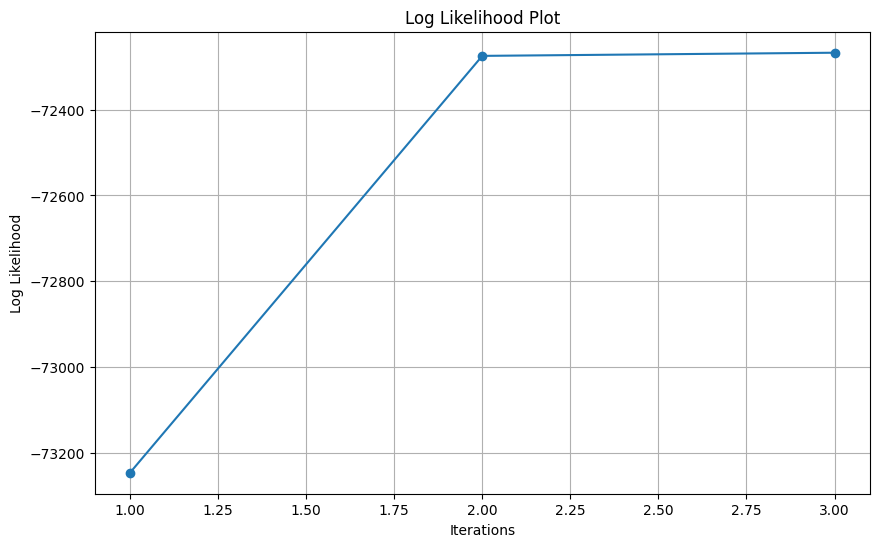

In [83]:
gmm = GMM(n_components = 15, iterations = 20, threshold = 1e-20)
means_,covariances_,prior_ = gmm.fit(customer_data)

# print(gmm.means_)
# print(gmm.covariances_)
# print(gmm.prior_)
print(gmm.log_likelihood_trace)
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(gmm.log_likelihood_trace)+1), gmm.log_likelihood_trace, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood Plot')
plt.grid(True)
plt.show()


# sklearn_gmm = GaussianMixture(n_components=gmm.n_components, covariance_type='full', tol=gmm.threshold, max_iter=gmm.iterations, random_state=42)
# sklearn_gmm.means_init = means_
# sklearn_gmm.covariances_init = covariances_
# sklearn_gmm.weights_init = prior_
# sklearn_gmm.fit(customer_data)


# # Compare the results
# print("Custom GMM Means:")
# print(gmm.means_)
# print("Scikit-learn GMM Means:")
# print(sklearn_gmm.means_)

# print("\nCustom GMM Covariances:")
# print(gmm.covariances_)
# print("Scikit-learn GMM Covariances:")
# print(sklearn_gmm.covariances_)

# print("\nCustom GMM Priors:")
# print(gmm.prior_)
# print("Scikit-learn GMM Priors:")
# print(sklearn_gmm.weights_)

Iteration
[[0.17025267 4.01162216]
 [3.3191681  0.38155965]
 [0.50705434 2.28888058]]
[[[ 0.43876915 -0.4219003 ]
  [-0.4219003   3.44613577]]

 [[ 2.99463223  0.10906548]
  [ 0.10906548  0.760211  ]]

 [[ 0.54476627 -0.34964151]
  [-0.34964151  4.37585632]]]
[0.19000218 0.36077201 0.44922408]
Iteration
[[0.17025267 4.01162216]
 [3.3191681  0.38155965]
 [0.50705434 2.28888058]]
[[[ 0.43876915 -0.4219003 ]
  [-0.4219003   3.44613577]]

 [[ 2.99463223  0.10906548]
  [ 0.10906548  0.760211  ]]

 [[ 0.54476627 -0.34964151]
  [-0.34964151  4.37585632]]]
[0.19000218 0.36077201 0.44922408]
Iteration
[[0.14935684 4.22833248]
 [3.13547678 0.50210553]
 [0.60199479 2.13250881]]
[[[ 0.39150457 -0.50002889]
  [-0.50002889  2.80304376]]

 [[ 3.680224   -0.09437051]
  [-0.09437051  0.70771816]]

 [[ 0.55131313 -0.51708818]
  [-0.51708818  4.70060125]]]
[0.19184716 0.37199154 0.4361613 ]
Iteration
[[0.09281043 4.49357513]
 [3.0048065  0.54053277]
 [0.65101238 2.00987837]]
[[[ 0.34505766 -0.37956765]
 

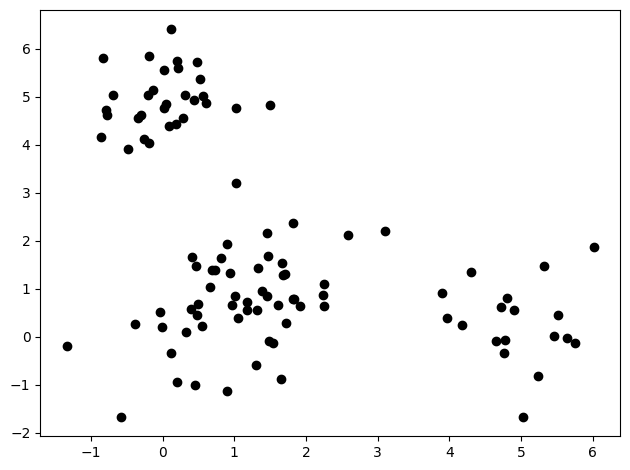

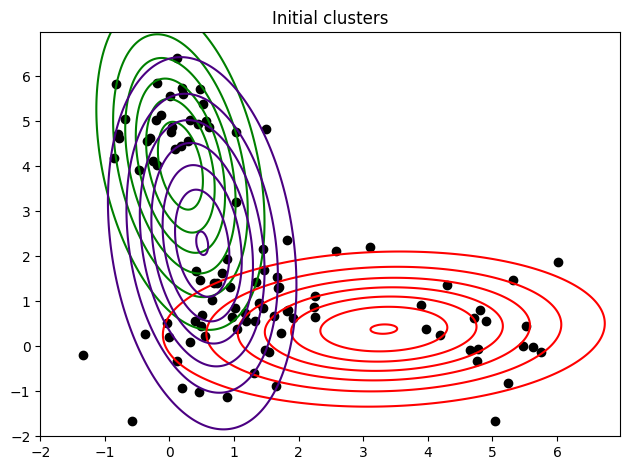

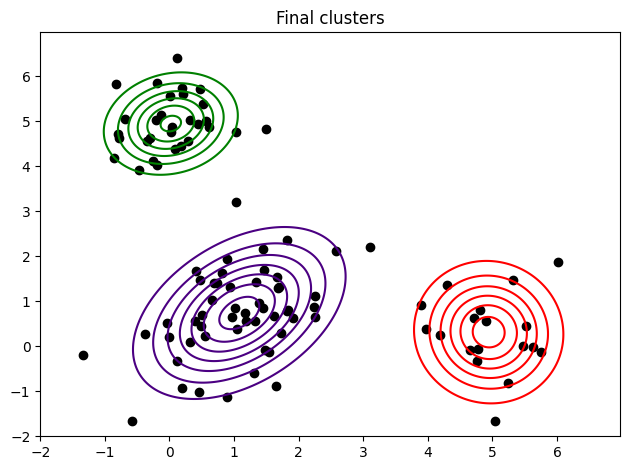

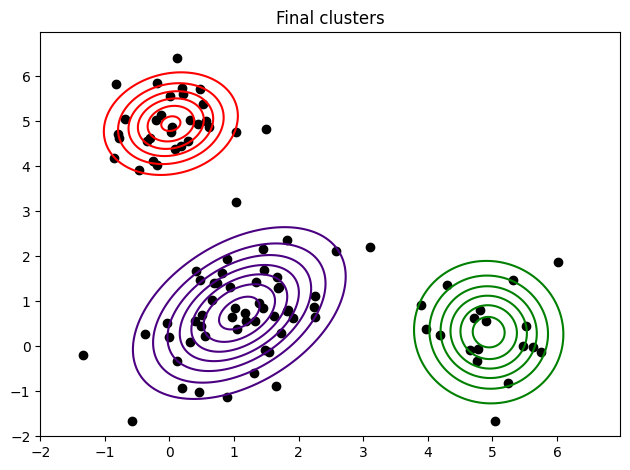

In [80]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [5, 0],
    [1, 1],
    [0, 5]
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 4, 1 / 2, 1 / 4]

# generate data
np.random.seed(4)
X = generate_data(100, init_means, init_covariances, init_weights)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])

    plt.title(title)
    plt.tight_layout()

gmm = GMM(n_components = 3, iterations= 1, threshold = 1e-4)
gmm.fit(X)

plot_contours(X, gmm.means_, gmm.covariances_, 'Initial clusters')

gmm = GMM(n_components = 3, iterations = 50, threshold = 1e-4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_contours(X, gmm.means_, gmm.covariances_, 'Final clusters')
# use library to confirm results
gmm = GaussianMixture(n_components = 3, covariance_type = 'full', 
                      max_iter = 600, random_state = 3)
gmm.fit(X)

print('converged or not: ', gmm.converged_)
plot_contours(X, gmm.means_, gmm.covariances_, 'Final clusters')

# GMM on Wine Dataset

In [ ]:
from sklearn.datasets import load_wine
data = load_wine()
